<a href="https://colab.research.google.com/github/jihun0423/Dacon-Hansol-img-classification/blob/main/%EB%9D%BC%EB%B2%A8%EB%B3%84_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EC%A6%9D%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import re
from glob import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, SubsetRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import torchvision.transforms as transforms

from torchvision.transforms.functional import to_pil_image

import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
# WeightedRandomSampler를 이용하여 이미지 개수를 늘린 뒤 학습한 결과, 과대적합으로 인하여 weighted f1 score가 굉장히 낮게 나왔다. 
# 따라서, image의 개수가 매우 적은 라벨들에 한해서만 늘리기로 결정.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
base_dir = '/content/gdrive/MyDrive/open (2)/'

In [ ]:
train_folder = glob(base_dir + 'train/*')

train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp

In [ ]:
plus_folder = glob(base_dir + 'plus/*')

plus_path = []
for folder in plus_folder:
    tmp = glob(folder + '/*')
    plus_path += tmp

In [ ]:
train_df = pd.DataFrame(train_path, columns=['path'])
train_df['label'] = train_df['path'].apply(lambda x: x.split('/')[-2])
train_df


,path,label
0,/content/gdrive/MyDrive/open (2)/train/가구수ᄌ...,가구수정
1,/content/gdrive/MyDrive/open (2)/train/가구수ᄌ...,가구수정
2,/content/gdrive/MyDrive/open (2)/train/가구수ᄌ...,가구수정
3,/content/gdrive/MyDrive/open (2)/train/가구수ᄌ...,가구수정
4,/content/gdrive/MyDrive/open (2)/train/가구수ᄌ...,가구수정
...,...,...
3452,/content/gdrive/MyDrive/open (2)/train/틈새과...,틈새과다
3453,/content/gdrive/MyDrive/open (2)/train/틈새과...,틈새과다
3454,/content/gdrive/MyDrive/open (2)/train/틈새과...,틈새과다
3455,/content/gdrive/MyDrive/open (2)/train/틈새과...,틈새과다


In [ ]:
plus_df = pd.DataFrame(plus_path, columns=['path'])
plus_df['label'] = plus_df['path'].apply(lambda x: x.split('/')[-2])
plus_df


,path,label
0,/content/gdrive/MyDrive/open (2)/plus/8/반점...,8
1,/content/gdrive/MyDrive/open (2)/plus/8/반점...,8
2,/content/gdrive/MyDrive/open (2)/plus/8/반점...,8
3,/content/gdrive/MyDrive/open (2)/plus/8/반점...,8
4,/content/gdrive/MyDrive/open (2)/plus/8/반점...,8
5,/content/gdrive/MyDrive/open (2)/plus/8/반점...,8
6,/content/gdrive/MyDrive/open (2)/plus/8/반점...,8
7,/content/gdrive/MyDrive/open (2)/plus/16/틈새...,16
8,/content/gdrive/MyDrive/open (2)/plus/16/틈새...,16
9,/content/gdrive/MyDrive/open (2)/plus/16/틈새...,16


In [ ]:
plus_df['label']=plus_df['label'].astype(int)

In [ ]:
train_df['label'].value_counts()

훼손                 1405
오염                  595
걸레받이수정        307
꼬임                  210
터짐                  162
곰팡이               145
오타공                142
몰딩수정            130
면불량               99
석고수정              57
들뜸                  54
피스                    51
창틀,문틀수정      27
울음                  22
이음부불량           17
녹오염                14
가구수정               12
틈새과다                5
반점                   3
Name: label, dtype: int64

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label']) # 라벨 인코딩

In [ ]:
train_df['label'].value_counts()

18    1405
10     595
1      307
3      210
15     162
2      145
11     142
7      130
6       99
9       57
5       54
17      51
14      27
12      22
13      17
4       14
0       12
16       5
8        3
Name: label, dtype: int64

In [ ]:
df = pd.concat([train_df,plus_df])

In [ ]:
df

,path,label
0,/content/gdrive/MyDrive/open (2)/train/가구수ᄌ...,0
1,/content/gdrive/MyDrive/open (2)/train/가구수ᄌ...,0
2,/content/gdrive/MyDrive/open (2)/train/가구수ᄌ...,0
3,/content/gdrive/MyDrive/open (2)/train/가구수ᄌ...,0
4,/content/gdrive/MyDrive/open (2)/train/가구수ᄌ...,0
...,...,...
7,/content/gdrive/MyDrive/open (2)/plus/16/틈새...,16
8,/content/gdrive/MyDrive/open (2)/plus/16/틈새...,16
9,/content/gdrive/MyDrive/open (2)/plus/16/틈새...,16
10,/content/gdrive/MyDrive/open (2)/plus/16/틈새...,16


In [ ]:
df['label'].value_counts()

18    1405
10     595
1      307
3      210
15     162
2      145
11     142
7      130
6       99
9       57
5       54
17      51
14      27
12      22
13      17
4       14
0       12
8       10
16      10
Name: label, dtype: int64

In [ ]:
# 데이터가 매우 적은 반점, 틈새과다의 경우 외부에서 데이터를 더 보강 할 예정.
# 데이터 갯수가 30개 이하인 라벨들에 한해서 augmentate후 개수를 5배로 늘릴 예정
# 훼손을 제외한 나머지 라벨들은 데이터를 2배로 늘릴 예정

In [ ]:
l1 = [8,16,0,4,13,12,14]
l2 = [17,5,9]
l3 = [6,7,11,2,15,3,1]
l4 = [18]

In [ ]:
for l in l1:
  print(l)

8
16
0
4
13
12
14


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms is not None:
            image = self.transforms(image)
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [ ]:
import torchvision.transforms as transforms
augmentate = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((600, 600)),
        transforms.RandomCrop((520, 520)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomHorizontalFlip(p=0.7),
        transforms.Resize((520, 520)),
    ])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label, transforms=None):
        self.img_path_list = img_path_list
        self.label = label
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label is not None:
            label = self.label[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [ ]:
albumentations.Compose([
            albumentations.Sharpen(p=0.7),
            albumentations.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=0.3),
            albumentations.FancyPCA(alpha=0.1, p=0.3),
            albumentations.Emboss(p=0.5),
          
            albumentations.Transpose(p=0.3),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.RandomRotate90(p=0.5),
            albumentations.VerticalFlip(p=0.5),

            albumentations.CLAHE(clip_limit=5, p=0.4),
            albumentations.ElasticTransform(alpha_affine=30, p=0.4), 
            albumentations.Posterize(p=0.5),

            albumentations.GaussNoise(p=0.3),
            albumentations.GaussianBlur(blur_limit=(1, 5), p=0.3),
            albumentations.GlassBlur(sigma=0.1, max_delta=2, iterations=1, p=0.2),  
            albumentations.GridDistortion(num_steps=20, distort_limit=0.3, border_mode=1, p=0.2), 
            ])

NameError: ignored

In [ ]:
from albumentations.pytorch import ToTensorV2
augmentate = A.Compose([A.Sharpen(p=0.7),
                        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=0.3),
                        A.FancyPCA(alpha=0.1, p=0.3),
                        A.Emboss(p=0.5),

                        A.HorizontalFlip(p=0.5),
                        A.ColorJitter(brightness=0.2, contrast=0.2), 
                        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
                        A.CLAHE(always_apply=False, p=0.5, clip_limit=(1, 15), tile_grid_size=(8, 8)),       
                        A.GaussNoise(p=0.3),
                        A.GaussianBlur(blur_limit=(1, 5), p=0.3),
                        A.GlassBlur(sigma=0.1, max_delta=2, iterations=1, p=0.2),                         
                        A.Resize(800,800),
                        A.RandomCrop(780, 780),
                        ToTensorV2()
                        ])

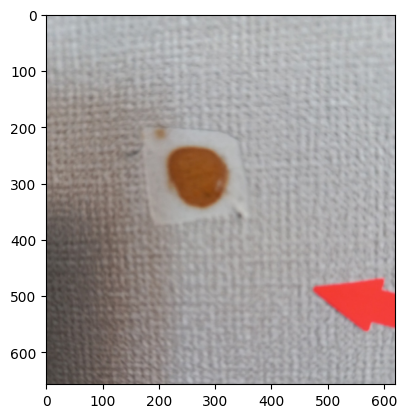

In [ ]:
import matplotlib.pyplot as plt
image = cv2.imread(df.loc[df['label']==4,'path'][674])
fix_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(fix_img)


In [ ]:
augmentate_4 = CustomDataset(df.loc[df['label']==8,'path'].values, df.loc[df['label']==8,'label'].values, augmentate)

In [ ]:
augmentate_loader = DataLoader(augmentate_4, batch_size = 1, shuffle=False, num_workers=8,pin_memory=True)

In [ ]:
augmentate_loader

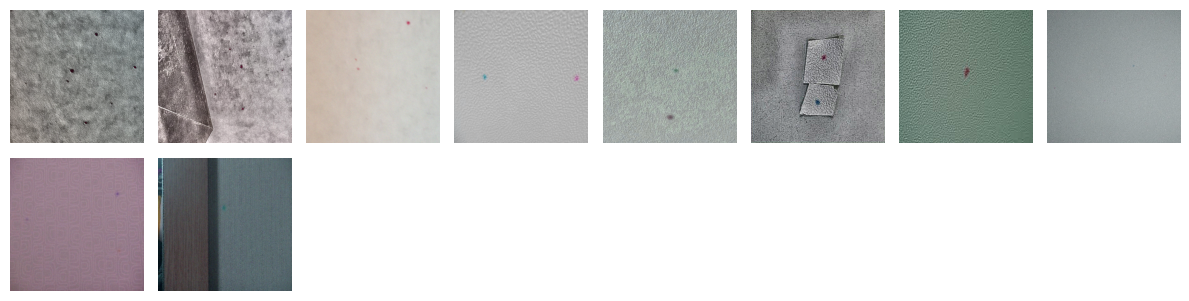

In [ ]:
plt.figure(figsize = (12,12))
for i,(image,label) in enumerate(augmentate_loader):
  plt.subplot(8,8,i+1)
  plt.imshow(to_pil_image(image[0]))
  plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train_augmentate = CustomDataset(train_df['path'].values, train_df['label'].values, augmentate)
augmentate_loader = DataLoader(train_augmentate, batch_size = 1, shuffle=False, num_workers=0)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import os
for i in range(0,19):
  os.mkdir("/content/gdrive/MyDrive/open (2)/aug/"+f'{i}')               # 이미지 저장을 위해 폴더 생성

In [ ]:
l1

[8, 16, 0, 4, 13, 12, 14]

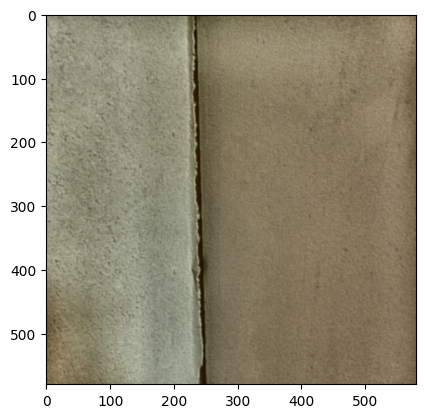

In [ ]:
for i, (inputs,labels) in enumerate(augmentate_loader):
  plt.imshow(to_pil_image(inputs[0]))
  break;

In [ ]:
num=0
for label in l1:
  augmentate_ = CustomDataset(df.loc[df['label']==label,'path'].values, df.loc[df['label']==label,'label'].values, augmentate)
  augmentate_loader = DataLoader(augmentate_, batch_size = 1, shuffle=False, num_workers=8,pin_memory=True)
  for epoch in range(0,29):
    for i, (inputs,labels) in enumerate(augmentate_loader):
      aug_img = to_pil_image(inputs[0])
      aug_img.save('/content/gdrive/MyDrive/open (2)/aug/'+f'{int(labels)}/'+f'{num}.jpg')
      num=num+1

In [ ]:
l2

[17, 5, 9]

In [ ]:
for label in l2:
  augmentate_ = CustomDataset(df.loc[df['label']==label,'path'].values, df.loc[df['label']==label,'label'].values, augmentate)
  augmentate_loader = DataLoader(augmentate_, batch_size = 1, shuffle=False, num_workers=8,pin_memory=True)
  for epoch in range(0,16):
    for i, (inputs,labels) in enumerate(augmentate_loader):
      aug_img = to_pil_image(inputs[0])
      aug_img.save('/content/gdrive/MyDrive/open (2)/aug/'+f'{int(labels)}/'+f'{num}.jpg')
      num=num+1

In [ ]:
l3

[6, 7, 11, 2, 15, 3, 1]

In [ ]:
for label in l3:
  augmentate_ = CustomDataset(df.loc[df['label']==label,'path'].values, df.loc[df['label']==label,'label'].values, augmentate)
  augmentate_loader = DataLoader(augmentate_, batch_size = 1, shuffle=False, num_workers=8,pin_memory=True)
  for epoch in range(0,5):
    for i, (inputs,labels) in enumerate(augmentate_loader):
      aug_img = to_pil_image(inputs[0])
      aug_img.save('/content/gdrive/MyDrive/open (2)/aug/'+f'{int(labels)}/'+f'{num}.jpg')
      num=num+1

In [ ]:
l4

[18]

In [ ]:
for label in l4:
  augmentate_ = CustomDataset(df.loc[df['label']==label,'path'].values, df.loc[df['label']==label,'label'].values, augmentate)
  augmentate_loader = DataLoader(augmentate_, batch_size = 1, shuffle=False, num_workers=8,pin_memory=True)
  for epoch in range(0,1):
    for i, (inputs,labels) in enumerate(augmentate_loader):
      aug_img = to_pil_image(inputs[0])
      aug_img.save('/content/gdrive/MyDrive/open (2)/aug/'+f'{int(labels)}/'+f'{num}.jpg')
      num=num+1

In [ ]:
num=0
for label in l1:
  augmentate_ = CustomDataset(df.loc[df['label']==label,'path'].values, df.loc[df['label']==label,'label'].values, augmentate)
  augmentate_loader = DataLoader(augmentate_, batch_size = 1, shuffle=False, num_workers=8,pin_memory=True)
  for epoch in range(0,5):
    for i, (inputs,labels) in enumerate(augmentate_loader):
      aug_img = to_pil_image(inputs[0])
      aug_img.save('/content/gdrive/MyDrive/open (2)/aug/'+f'{int(labels)}/'+f'{num}.jpg')
      num=num+1